In [1]:
%load_ext lab_black

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.stats.stats import pearsonr
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import (
    LinearRegression,
    LassoCV,
)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

from pprint import pprint

In [3]:
def cross_validate_report(model, X, y, show=True, return_coef=False):
    scoring = ["neg_mean_squared_error", "neg_root_mean_squared_error"]

    result = cross_validate(model, X, y, scoring=scoring, return_estimator=True)

    coef_estimates = [list(estimator.coef_) for estimator in result["estimator"]]

    cv_test_mse = -result["test_neg_mean_squared_error"].mean()
    cv_test_rmse = -result["test_neg_root_mean_squared_error"].mean()

    if show:
        print("Test Metrics")
        print(f"CV Test MSE: {cv_test_mse}")
        print(f"CV Test RMSE: {cv_test_rmse}")
        print()
        print(f"Coefficient Estimates Across Folds: ")
        pprint(coef_estimates)

    if return_coef:
        return coef_estimates

In [4]:
SEED = 1232
N_OBS = 1000

In [5]:
np.random.seed(SEED)

In [6]:
x_1 = np.random.uniform(0, 10, N_OBS)
e = np.random.normal(0, 1, N_OBS)
y = 3 + 2 * x_1 + e

In [7]:
X_1 = x_1.reshape(-1, 1)

cross_validate_report(LinearRegression(), X_1, y)

Test Metrics
CV Test MSE: 1.082097929792948
CV Test RMSE: 1.037556273372198

Coefficient Estimates Across Folds: 
[[1.9941598842341444],
 [2.003269153324389],
 [1.9952964817410503],
 [1.9894677458455363],
 [1.9885074228378194]]


In [8]:
g = np.random.normal(0, 0.1, N_OBS)
x_2 = -x_1 + g

In [9]:
r, _ = pearsonr(x_1, x_2)
print(r)

-0.9994011519880747


In [10]:
X_2 = x_2.reshape(-1, 1)

cross_validate_report(LinearRegression(), X_2, y)

Test Metrics
CV Test MSE: 1.1168712272079149
CV Test RMSE: 1.0537724203735295

Coefficient Estimates Across Folds: 
[[-1.9903178261047956],
 [-1.998657217144718],
 [-1.9890440565195024],
 [-1.983499647509015],
 [-1.9834489190091635]]


In [11]:
X = np.concatenate((X_1, X_2), axis=1)
cross_validate_report(LinearRegression(), X, y)

Test Metrics
CV Test MSE: 1.0835298196452652
CV Test RMSE: 1.0382160432570071

Coefficient Estimates Across Folds: 
[[1.8029027470038652, -0.19109142585953637],
 [1.6384195458596402, -0.3643687849363034],
 [1.8564194447233686, -0.1385964284121925],
 [2.0454448403573444, 0.055878025959504085],
 [1.8401177092087693, -0.14817814320570755]]


In [12]:
data = []

for gamma_std in np.linspace(0.01, 0.2):
    g = np.random.normal(0, gamma_std, N_OBS)
    x_2 = -x_1 + g
    X_2 = x_2.reshape(-1, 1)
    X = np.concatenate((X_1, X_2), axis=1)

    r, _ = pearsonr(x_1, x_2)
    coefs_across_folds = cross_validate_report(
        LinearRegression(), X, y, show=False, return_coef=True
    )

    for coefs_fold in coefs_across_folds:
        beta_1 = coefs_fold[0]
        beta_2 = coefs_fold[1]
        data.append(
            {"gamma_std": gamma_std, "r": r, "beta_1": beta_1, "beta_2": beta_2}
        )

In [13]:
plot_df = pd.DataFrame(data)

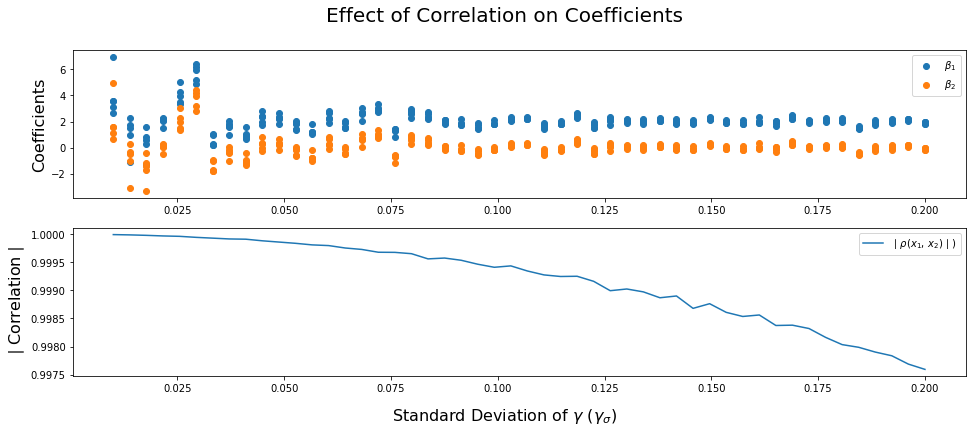

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 6))

coef_plot = axes[0]
corr_plot = axes[1]

coef_plot.scatter(plot_df["gamma_std"], plot_df["beta_1"], label=r"$\beta_{1}$")
coef_plot.scatter(plot_df["gamma_std"], plot_df["beta_2"], label=r"$\beta_{2}$")
coef_plot.legend(loc="upper right")
coef_plot.set_ylabel(r"Coefficients", size=16)

corr_plot.plot(
    plot_df["gamma_std"],
    plot_df["r"].abs(),
    label=r"$\mid\rho(x_{1},\,x_{2})\mid$)",
)
corr_plot
corr_plot.legend(loc="upper right")
corr_plot.yaxis.set_major_formatter("{x:.4f}")
corr_plot.set_ylabel(r"$\mid$Correlation$\mid$", size=16)

fig.suptitle("Effect of Correlation on Coefficients", size=20)
fig.supxlabel(r"Standard Deviation of $\gamma$ ($\gamma_{\sigma}$)", size=16)

plt.show()